# Wide and Deep Networks for Credit Score Classification

By: Joe, Sellett, Haiyan Cai, and Cole Wagner

In [178]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import (
    Activation,
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
)
from tensorflow.keras.utils import FeatureSpace


In [179]:
credit_df = pd.read_csv("credit_score_cleaned.csv")

In [180]:
credit_df["payment_behaviour"].value_counts()

payment_behaviour
Low_spent_Small_value_payments      26503
High_spent_Medium_value_payments    18431
Low_spent_Medium_value_payments     14516
High_spent_Large_value_payments     14438
High_spent_Small_value_payments     11850
Low_spent_Large_value_payments      10958
Name: count, dtype: int64

## Data Preparation

### Drop Unnecessary Columns

Before proceeding with the modeling phase of this project, we will remove the following variables: customer_id, name, ssn, and type_of_loan. The customer_id field is being excluded because we already have a more robust unique identifier, id, which will serve as our primary reference for credit score reports. Similarly, name and ssn offer no predictive value and are being dropped to maintain data privacy and reduce dimensionality. Each of these variables contains approximately 8,000–12,000 unique values, whereas id contains over 96,000. Lastly, type_of_loan is being excluded for its high number of categories (50+), which would introduce unnecessary complexity. Instead, we will rely on the credit_mix variable, which summarizes loan diversity in a more manageable form as a category with only 3 unique values (standard, good, and bad).

In [181]:
credit_df = credit_df.drop(
    columns=["customer_id", "name", "ssn", "type_of_loan"]
)

### Create Feature Space for Preprocessing

In [182]:
def create_dataset_from_dataframe(
    x_input: pd.DataFrame, y_input: pd.Series, batch_size: int
) -> tf.data.Dataset:
    """Convert a pandas dataframe to a TensorFlow Dataset.

    Parameters
    ----------
    x_input : pd.DataFrame
        The input pandas dataframe containing the features.
    y_input : pd.Series
        The input pandas series containing the labels.
    batch_size : int
        The number of rows per batch in the TensorFlow Dataset.

    Returns
    -------
    tf.data.Dataset
        A TensorFlow Dataset object created from the input dataframe.

    """
    df_dict = {
        key: value.to_numpy()[:, np.newaxis]
        for key, value in x_input.items()
    }

    tf_ds = tf.data.Dataset.from_tensor_slices((dict(df_dict), y_input))
    tf_ds = tf_ds.batch(batch_size)
    return tf_ds.prefetch(batch_size)


In [183]:
# Sample schema based on the dataframe info
categorical_features = [
    "month",
    "occupation",
    "credit_mix",
    "payment_of_min_amount",
    "payment_behaviour",
]
numeric_features = [
    "age",
    "annual_income",
    "monthly_inhand_salary",
    "credit_history_age",
    "total_emi_per_month",
    "num_bank_accounts",
    "num_credit_card",
    "interest_rate",
    "num_of_loan",
    "delay_from_due_date",
    "num_of_delayed_payment",
    "changed_credit_limit",
    "num_credit_inquiries",
    "outstanding_debt",
    "credit_utilization_ratio",
    "amount_invested_monthly",
    "monthly_balance",
]

# Define feature configs
feature_space = FeatureSpace(
    features={
        **{
            name: FeatureSpace.string_categorical(num_oov_indices=0)
            for name in categorical_features
        },
        **{
            name: FeatureSpace.float_normalized()
            for name in numeric_features
        },
    },
    crosses=[
        FeatureSpace.cross(
            feature_names=("occupation", "credit_mix"),
            crossing_dim=15 * 3,
        ),
        FeatureSpace.cross(
            feature_names=("payment_of_min_amount", "payment_behaviour"),
            crossing_dim=6 * 2,
        ),
    ],
    output_mode="dict",
)

### Cross-Product Feature Justification

First, we created a cross-product feature between `occupation` and `credit_mix`. This combination allows us to capture differences in credit behavior across various professional backgrounds. For example, a neurosurgeon with a bad credit mix may exhibit very different financial behavior compared to an unemployed individual with the same credit mix. While each variable on its own may offer limited insight, their combination provides a more nuanced understanding of how occupation and credit diversity interact.

Another cross-product feature we created combines `payment_of_min_amount` and `payment_behavior`. The `payment_of_min_amount` variable is a binary indicator showing whether an individual made only the minimum payment on their debt for that month. In contrast, `payment_behavior` provides a broader description of a person’s spending and repayment patterns, such as “low spent, high payments” or “high spent, medium payments.” Since these two variables are closely related, their combination may help the model better capture nuanced repayment behaviors and improve its ability to distinguish between risk profiles.

### Performance Metric Justification

Given the nature of our project, it’s important to evaluate our model using multiple metrics rather than relying solely on accuracy. In credit risk classification, false predictions carry different levels of business risk. For example, if a high-risk individual is incorrectly classified as low-risk, the company may absorb the financial loss from a bad loan. This makes recall especially important, as it tells us how well the model identifies actual high-risk cases and helps minimize false negatives. At the same time, precision matters because it reflects how accurate our high-risk predictions are, which ensures we don’t wrongly classify low-risk individuals as high-risk. A high recall means we’re catching most of the truly risky borrowers, while a high precision score means we’re correctly labeling them. Since both metrics are critical and often trade off against each other, we focus on the F1 score, which represents the harmonic mean of precision and recall. The F1 score gives us a more balanced and realistic measure of performance, especially in a setting where both catching risky borrowers and avoiding false alarms are essential to the business.

### Data Splitting

We have chosen to use a standard 80/20 train-test split for dividing our dataset. Given the size of our data (approximately 100,000 observations) we believe this approach is justified and will provide a reliable estimate of model performance. If our dataset were significantly smaller (around 1,000 observations), we might opt for 10-fold cross-validation to obtain a more stable and generalized result. Additionally, the 80/20 split offers a clear advantage in terms of computational efficiency. While 10-fold cross-validation could yield a marginal improvement in performance estimates, it would come at a considerable computational cost that is unnecessary given the scale of our data.

In [184]:
x_train, x_test, y_train, y_test = train_test_split(
    credit_df.drop(columns=["credit_score", "id"]),
    credit_df["credit_score"],
    test_size=0.2,
    random_state=7324,
    stratify=credit_df["credit_score"],
)

In [185]:
# Convert data to TensorFlow Datasets
train_ds = create_dataset_from_dataframe(x_train, y_train, batch_size=32)
test_ds = create_dataset_from_dataframe(x_test, y_test, batch_size=32)

In [186]:
# Apply feature space to datasets
train_ds_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_no_labels)
processed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)
processed_train_ds = processed_train_ds.prefetch(tf.data.AUTOTUNE)

test_ds_no_labels = test_ds.map(lambda x, _: x)
processed_test_ds = test_ds.map(
    lambda x, y: (feature_space(x), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)
processed_test_ds = processed_test_ds.prefetch(tf.data.AUTOTUNE)


# Modeling

In [ ]:
def setup_embedding_from_encoding(encoded_features, col_name):
    # what the maximum integer value for this variable?

    # get the size of the feature
    x = encoded_features[col_name]
    N = x.shape[1]

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(
        input_dim=N,
        output_dim=int(np.sqrt(N)),
        input_length=1,
        name=col_name + "_embed",
    )(x)

    x = Flatten()(
        x
    )  # get rid of that pesky extra dimension (for time of embedding)

    return x

In [188]:
def build_wide_branches(encoded_features, crossed_columns):
    if not crossed_columns:
        return None

    # we need to create separate lists for each branch
    crossed_outputs = []

    # for each crossed variable, make an embedding
    for col in crossed_columns:
        x = setup_embedding_from_encoding(encoded_features, col)

        # save these outputs in list to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    return Concatenate(name="wide_concat")(crossed_outputs)


In [ ]:
def build_deep_branches(encoded_features, hidden_units=[64, 32]):
    # reset this input branch
    all_deep_branch_outputs = []

    # for each numeric variable, just add it in after embedding
    for col in numeric_features:
        x = encoded_features[col]
        # x = tf.cast(x,float) # cast an integer as a float here
        all_deep_branch_outputs.append(x)

    # for each categorical variable
    for col in categorical_features:
        # get the output tensor from ebedding layer
        x = setup_embedding_from_encoding(encoded_features, col)

        # save these outputs in list to concatenate later
        all_deep_branch_outputs.append(x)
    deep_branch = Concatenate(name="embed_concat")(all_deep_branch_outputs)
    i = 1
    for layers in hidden_units:
        name = "deep" + str(i)
        i += 1
        deep_branch = Dense(units=layers, activation="relu", name=name)(
            deep_branch
        )

    return deep_branch

In [ ]:
from tensorflow.keras.utils import plot_model


def build_wide_deep_networks(crossed_columns, hidden_units=[64, 32]):
    dict_inputs = feature_space.get_inputs()  # need to use unprocessed features here, to gain access to each output
    encoded_features = feature_space.get_encoded_features()
    # these features have been encoded

    wide_branch = build_wide_branches(encoded_features, crossed_columns)
    deep_branch = build_deep_branches(encoded_features, hidden_units)

    # merge the deep and wide branch
    # final_branch = Concatenate(name="concat_deep_wide")(
    #     [deep_branch, wide_branch]
    # )
    if wide_branch is not None:
        final_branch = Concatenate(name="concat_deep_wide")(
            [deep_branch, wide_branch]
        )
    else:
        final_branch = Concatenate(name="concat_deep_wide")([deep_branch])

    final_branch = Dense(units=3, activation="softmax", name="combined")(
        final_branch
    )

    # encoded features input, fast
    training_model = keras.Model(
        inputs=encoded_features, outputs=final_branch
    )
    training_model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    training_model.summary()

    # non-encoded, perform redundant operations
    inference_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
    inference_model.compile(
        loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    # plot_model(
    #     training_model,
    #     to_file="model.png",
    #     show_shapes=True,
    #     show_layer_names=True,
    #     rankdir="LR",
    #     expand_nested=False,
    #     dpi=96,
    # )
    return training_model

## Model 1

- Crossed Features: occupation_X_credit_mix

- 2 hidden layers with 64 and 32 units

- Baseline model with a simple cross-product to capture interaction between occupation and credit mix.

In [ ]:
crosses = ["occupation_X_credit_mix"]
hidden_units = [64, 32]
training_model = build_wide_deep_networks(crosses, hidden_units)


history = training_model.fit(
    processed_train_ds,
    epochs=10,
    validation_data=processed_test_ds,
    verbose=2,
)

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_520> which has name 'keras_tensor_520'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'amount_invested_monthly' mapping to value <KerasTensor shape=(None, 1), dtype=float3

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_540CL… │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_541CL… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_539CL… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_543CL… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_542CL… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month_embed         │ (None, 8, 2)      │         16 │ keras_tensor_540… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation_embed    │ (None, 15, 3)     │         45 │ keras_tensor_541… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credit_mix_embed    │ (None, 3, 1)      │          3 │ keras_tensor_539… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_of_min_amo… │ (None, 2, 1)      │          2 │ keras_tensor_543… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_behaviour_… │ (None, 6, 2)      │         12 │ keras_tensor_542… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_520CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_521CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_522CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_523CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_524CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_525CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_526CL… │ (None, 1)         │          0 │ -               

 Total params: 9,481 (37.04 KB)

 Trainable params: 9,481 (37.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_520CLONE', 'amount_invested_monthly': 'keras_tensor_535CLONE', 'annual_income': 'keras_tensor_521CLONE', 'changed_credit_limit': 'keras_tensor_531CLONE', 'credit_history_age': 'keras_tensor_523CLONE', 'credit_mix': 'keras_tensor_539CLONE', 'credit_utilization_ratio': 'keras_tensor_534CLONE', 'delay_from_due_date': 'keras_tensor_529CLONE', 'interest_rate': 'keras_tensor_527CLONE', 'month': 'keras_tensor_540CLONE', 'monthly_balance': 'keras_tensor_536CLONE', 'monthly_inhand_salary': 'keras_tensor_522CLONE', 'num_bank_accounts': 'keras_tensor_525CLONE', 'num_credit_card': 'keras_tensor_526CLONE', 'num_credit_inquiries': 'keras_tensor_532CLONE', 'num_of_delayed_payment': 'keras_tensor_530CLONE', 'num_of_loan': 'keras_tensor_528CLONE', 'occupation': 'keras_tensor_541CLONE', 'o

2418/2418 - 3s - 1ms/step - accuracy: 0.6834 - loss: 0.6919 - val_accuracy: 0.7021 - val_loss: 0.6569
Epoch 2/10
2418/2418 - 2s - 951us/step - accuracy: 0.7019 - loss: 0.6481 - val_accuracy: 0.7041 - val_loss: 0.6457
Epoch 3/10
2418/2418 - 2s - 978us/step - accuracy: 0.7056 - loss: 0.6367 - val_accuracy: 0.7067 - val_loss: 0.6393
Epoch 4/10
2418/2418 - 2s - 947us/step - accuracy: 0.7078 - loss: 0.6292 - val_accuracy: 0.7076 - val_loss: 0.6353
Epoch 5/10
2418/2418 - 2s - 945us/step - accuracy: 0.7097 - loss: 0.6232 - val_accuracy: 0.7076 - val_loss: 0.6342
Epoch 6/10
2418/2418 - 2s - 945us/step - accuracy: 0.7124 - loss: 0.6181 - val_accuracy: 0.7092 - val_loss: 0.6335
Epoch 7/10
2418/2418 - 2s - 942us/step - accuracy: 0.7146 - loss: 0.6136 - val_accuracy: 0.7094 - val_loss: 0.6329
Epoch 8/10
2418/2418 - 2s - 946us/step - accuracy: 0.7168 - loss: 0.6094 - val_accuracy: 0.7102 - val_loss: 0.6321
Epoch 9/10
2418/2418 - 2s - 972us/step - accuracy: 0.7189 - loss: 0.6054 - val_accuracy: 0.71

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics as mt


def plot():
    plt.plot(history.history["loss"], label="training")
    plt.plot(history.history["val_loss"], label="validation")
    plt.legend()
    plt.show()


def get_performance():
    # we only need to do this to use sklearn metrics
    y_test = tf.concat([y for x, y in processed_test_ds], axis=0).numpy()

    # now lets see how well the model performed
    yhat_proba = training_model.predict(processed_test_ds)

    yhat = np.argmax(yhat_proba, axis=1)

    # 4. Use sklearn metrics
    print(mt.confusion_matrix(y_test, yhat))
    print(mt.classification_report(y_test, yhat, digits=4))


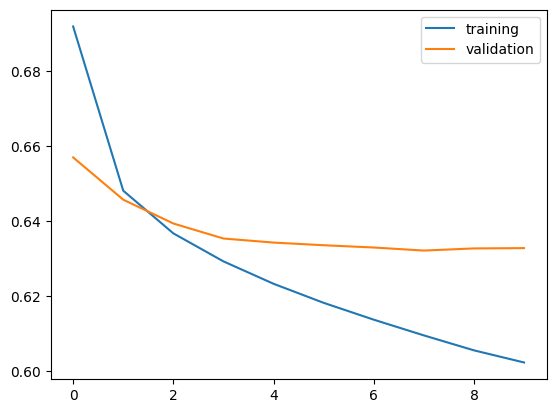

220/605 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_520CLONE', 'amount_invested_monthly': 'keras_tensor_535CLONE', 'annual_income': 'keras_tensor_521CLONE', 'changed_credit_limit': 'keras_tensor_531CLONE', 'credit_history_age': 'keras_tensor_523CLONE', 'credit_mix': 'keras_tensor_539CLONE', 'credit_utilization_ratio': 'keras_tensor_534CLONE', 'delay_from_due_date': 'keras_tensor_529CLONE', 'interest_rate': 'keras_tensor_527CLONE', 'month': 'keras_tensor_540CLONE', 'monthly_balance': 'keras_tensor_536CLONE', 'monthly_inhand_salary': 'keras_tensor_522CLONE', 'num_bank_accounts': 'keras_tensor_525CLONE', 'num_credit_card': 'keras_tensor_526CLONE', 'num_credit_inquiries': 'keras_tensor_532CLONE', 'num_of_delayed_payment': 'keras_tensor_530CLONE', 'num_of_loan': 'keras_tensor_528CLONE', 'occupation': 'keras_tensor_541CLONE', 'o

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step
[[3610 1536  351]
 [1277 7858 1166]
 [ 100 1143 2299]]
              precision    recall  f1-score   support

           0     0.7239    0.6567    0.6887      5497
           1     0.7458    0.7628    0.7542     10301
           2     0.6025    0.6491    0.6249      3542

    accuracy                         0.7118     19340
   macro avg     0.6907    0.6895    0.6893     19340
weighted avg     0.7133    0.7118    0.7119     19340



In [ ]:
plot()
get_performance()

## Model 2

- Crossed Features: occupation_X_credit_mix, payment_of_min_amount_X_payment_behaviour

- 2 hidden layers with 64 and 32 units

- Adds a second crossed feature to explore whether combining payment behavior patterns improves performance.

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_520> which has name 'keras_tensor_520'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'amount_invested_monthly' mapping to value <KerasTensor shape=(None, 1), dtype=float3

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_540CL… │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_541CL… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_539CL… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_543CL… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_542CL… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month_embed         │ (None, 8, 2)      │         16 │ keras_tensor_540… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation_embed    │ (None, 15, 3)     │         45 │ keras_tensor_541… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credit_mix_embed    │ (None, 3, 1)      │          3 │ keras_tensor_539… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_of_min_amo… │ (None, 2, 1)      │          2 │ keras_tensor_543… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_behaviour_… │ (None, 6, 2)      │         12 │ keras_tensor_542… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_520CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_521CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_522CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_523CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_524CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_525CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_526CL… │ (None, 1)         │          0 │ -               

 Total params: 9,625 (37.60 KB)

 Trainable params: 9,625 (37.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_520CLONE', 'amount_invested_monthly': 'keras_tensor_535CLONE', 'annual_income': 'keras_tensor_521CLONE', 'changed_credit_limit': 'keras_tensor_531CLONE', 'credit_history_age': 'keras_tensor_523CLONE', 'credit_mix': 'keras_tensor_539CLONE', 'credit_utilization_ratio': 'keras_tensor_534CLONE', 'delay_from_due_date': 'keras_tensor_529CLONE', 'interest_rate': 'keras_tensor_527CLONE', 'month': 'keras_tensor_540CLONE', 'monthly_balance': 'keras_tensor_536CLONE', 'monthly_inhand_salary': 'keras_tensor_522CLONE', 'num_bank_accounts': 'keras_tensor_525CLONE', 'num_credit_card': 'keras_tensor_526CLONE', 'num_credit_inquiries': 'keras_tensor_532CLONE', 'num_of_delayed_payment': 'keras_tensor_530CLONE', 'num_of_loan': 'keras_tensor_528CLONE', 'occupation': 'keras_tensor_541CLONE', 'o

2418/2418 - 3s - 1ms/step - accuracy: 0.6832 - loss: 0.6923 - val_accuracy: 0.6999 - val_loss: 0.6566
Epoch 2/10
2418/2418 - 2s - 956us/step - accuracy: 0.7034 - loss: 0.6473 - val_accuracy: 0.7034 - val_loss: 0.6454
Epoch 3/10
2418/2418 - 2s - 953us/step - accuracy: 0.7079 - loss: 0.6360 - val_accuracy: 0.7022 - val_loss: 0.6417
Epoch 4/10
2418/2418 - 2s - 984us/step - accuracy: 0.7101 - loss: 0.6286 - val_accuracy: 0.7038 - val_loss: 0.6378
Epoch 5/10
2418/2418 - 2s - 952us/step - accuracy: 0.7124 - loss: 0.6226 - val_accuracy: 0.7049 - val_loss: 0.6347
Epoch 6/10
2418/2418 - 2s - 950us/step - accuracy: 0.7145 - loss: 0.6176 - val_accuracy: 0.7068 - val_loss: 0.6321
Epoch 7/10
2418/2418 - 2s - 950us/step - accuracy: 0.7159 - loss: 0.6130 - val_accuracy: 0.7070 - val_loss: 0.6302
Epoch 8/10
2418/2418 - 2s - 959us/step - accuracy: 0.7187 - loss: 0.6088 - val_accuracy: 0.7073 - val_loss: 0.6303
Epoch 9/10
2418/2418 - 2s - 952us/step - accuracy: 0.7212 - loss: 0.6049 - val_accuracy: 0.70

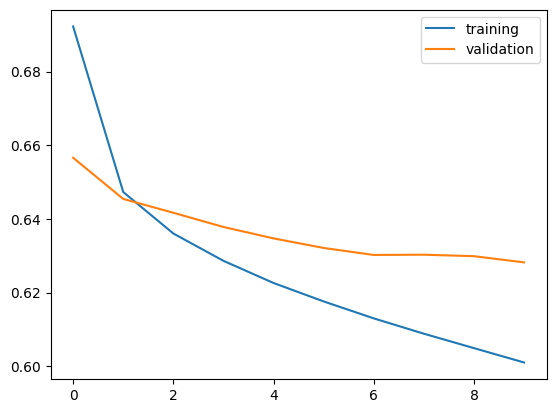

147/605 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_520CLONE', 'amount_invested_monthly': 'keras_tensor_535CLONE', 'annual_income': 'keras_tensor_521CLONE', 'changed_credit_limit': 'keras_tensor_531CLONE', 'credit_history_age': 'keras_tensor_523CLONE', 'credit_mix': 'keras_tensor_539CLONE', 'credit_utilization_ratio': 'keras_tensor_534CLONE', 'delay_from_due_date': 'keras_tensor_529CLONE', 'interest_rate': 'keras_tensor_527CLONE', 'month': 'keras_tensor_540CLONE', 'monthly_balance': 'keras_tensor_536CLONE', 'monthly_inhand_salary': 'keras_tensor_522CLONE', 'num_bank_accounts': 'keras_tensor_525CLONE', 'num_credit_card': 'keras_tensor_526CLONE', 'num_credit_inquiries': 'keras_tensor_532CLONE', 'num_of_delayed_payment': 'keras_tensor_530CLONE', 'num_of_loan': 'keras_tensor_528CLONE', 'occupation': 'keras_tensor_541CLONE', 'o

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step
[[3472 1692  333]
 [1202 7862 1237]
 [  87 1093 2362]]
              precision    recall  f1-score   support

           0     0.7293    0.6316    0.6769      5497
           1     0.7384    0.7632    0.7506     10301
           2     0.6007    0.6669    0.6321      3542

    accuracy                         0.7082     19340
   macro avg     0.6895    0.6872    0.6865     19340
weighted avg     0.7106    0.7082    0.7080     19340



In [ ]:
crosses = [
    "occupation_X_credit_mix",
    "payment_of_min_amount_X_payment_behaviour",
]
hidden_units = [64, 32]
training_model = build_wide_deep_networks(crosses, hidden_units)


history = training_model.fit(
    processed_train_ds,
    epochs=10,
    validation_data=processed_test_ds,
    verbose=2,
)

plot()
get_performance()

## Model 3

- Crossed Features: occupation_X_credit_mix, payment_of_min_amount_X_payment_behaviour

- 3 hidden layers with 128, 64, and 32

- add one more layer with 128 neurals to explore whether deeper networks improves performance.

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_520> which has name 'keras_tensor_520'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'amount_invested_monthly' mapping to value <KerasTensor shape=(None, 1), dtype=float3

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_540CL… │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_541CL… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_539CL… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_543CL… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_542CL… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month_embed         │ (None, 8, 2)      │         16 │ keras_tensor_540… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation_embed    │ (None, 15, 3)     │         45 │ keras_tensor_541… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credit_mix_embed    │ (None, 3, 1)      │          3 │ keras_tensor_539… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_of_min_amo… │ (None, 2, 1)      │          2 │ keras_tensor_543… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_behaviour_… │ (None, 6, 2)      │         12 │ keras_tensor_542… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_520CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_521CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_522CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_523CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_524CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_525CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_526CL… │ (None, 1)         │          0 │ -               

 Total params: 24,025 (93.85 KB)

 Trainable params: 24,025 (93.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_520CLONE', 'amount_invested_monthly': 'keras_tensor_535CLONE', 'annual_income': 'keras_tensor_521CLONE', 'changed_credit_limit': 'keras_tensor_531CLONE', 'credit_history_age': 'keras_tensor_523CLONE', 'credit_mix': 'keras_tensor_539CLONE', 'credit_utilization_ratio': 'keras_tensor_534CLONE', 'delay_from_due_date': 'keras_tensor_529CLONE', 'interest_rate': 'keras_tensor_527CLONE', 'month': 'keras_tensor_540CLONE', 'monthly_balance': 'keras_tensor_536CLONE', 'monthly_inhand_salary': 'keras_tensor_522CLONE', 'num_bank_accounts': 'keras_tensor_525CLONE', 'num_credit_card': 'keras_tensor_526CLONE', 'num_credit_inquiries': 'keras_tensor_532CLONE', 'num_of_delayed_payment': 'keras_tensor_530CLONE', 'num_of_loan': 'keras_tensor_528CLONE', 'occupation': 'keras_tensor_541CLONE', 'o

2418/2418 - 4s - 1ms/step - accuracy: 0.6904 - loss: 0.6800 - val_accuracy: 0.7034 - val_loss: 0.6496
Epoch 2/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7060 - loss: 0.6407 - val_accuracy: 0.7065 - val_loss: 0.6403
Epoch 3/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7095 - loss: 0.6288 - val_accuracy: 0.7070 - val_loss: 0.6390
Epoch 4/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7135 - loss: 0.6197 - val_accuracy: 0.7115 - val_loss: 0.6327
Epoch 5/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7161 - loss: 0.6105 - val_accuracy: 0.7096 - val_loss: 0.6310
Epoch 6/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7193 - loss: 0.6011 - val_accuracy: 0.7113 - val_loss: 0.6288
Epoch 7/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7247 - loss: 0.5918 - val_accuracy: 0.7126 - val_loss: 0.6272
Epoch 8/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7301 - loss: 0.5816 - val_accuracy: 0.7090 - val_loss: 0.6287
Epoch 9/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7344 - loss: 0.5718 - val_accuracy: 0.7094 - val_loss: 0

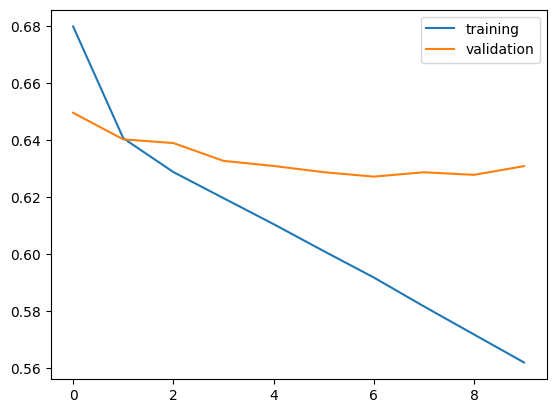

125/605 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_520CLONE', 'amount_invested_monthly': 'keras_tensor_535CLONE', 'annual_income': 'keras_tensor_521CLONE', 'changed_credit_limit': 'keras_tensor_531CLONE', 'credit_history_age': 'keras_tensor_523CLONE', 'credit_mix': 'keras_tensor_539CLONE', 'credit_utilization_ratio': 'keras_tensor_534CLONE', 'delay_from_due_date': 'keras_tensor_529CLONE', 'interest_rate': 'keras_tensor_527CLONE', 'month': 'keras_tensor_540CLONE', 'monthly_balance': 'keras_tensor_536CLONE', 'monthly_inhand_salary': 'keras_tensor_522CLONE', 'num_bank_accounts': 'keras_tensor_525CLONE', 'num_credit_card': 'keras_tensor_526CLONE', 'num_credit_inquiries': 'keras_tensor_532CLONE', 'num_of_delayed_payment': 'keras_tensor_530CLONE', 'num_of_loan': 'keras_tensor_528CLONE', 'occupation': 'keras_tensor_541CLONE', 'o

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step
[[3500 1660  337]
 [1247 7755 1299]
 [  66 1015 2461]]
              precision    recall  f1-score   support

           0     0.7272    0.6367    0.6790      5497
           1     0.7435    0.7528    0.7482     10301
           2     0.6007    0.6948    0.6443      3542

    accuracy                         0.7092     19340
   macro avg     0.6905    0.6948    0.6905     19340
weighted avg     0.7127    0.7092    0.7095     19340



In [ ]:
crosses = [
    "occupation_X_credit_mix",
    "payment_of_min_amount_X_payment_behaviour",
]

hidden_units = [128, 64, 32]

training_model = build_wide_deep_networks(crosses, hidden_units)


history = training_model.fit(
    processed_train_ds,
    epochs=10,
    validation_data=processed_test_ds,
    verbose=2,
)
plot()
get_performance()

### Analysis

From the visualization for Model1, Model2, and Model3, we can see that:
- overall, model3 achieved the best generalization performance compared with model1 and model2. model3 added one more layer, indicating the deeper network provides better generalization
- Model 2 outperforms Model 1 across all metrics, indicating that adding crossed feature(payment_of_min_amount and payment_behaviour) did helped memorization on capturing more patterns.

## standard multi-layer perceptron (MLP)

- Crossed Features: none; no wide branch 

- 2 hidden layers with 64, and 32

- compare MLP with model 3

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_520> which has name 'keras_tensor_520'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'amount_invested_monthly' mapping to value <KerasTensor shape=(None, 1), dtype=float3

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_540CL… │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_541CL… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_539CL… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_543CL… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_542CL… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month_embed         │ (None, 8, 2)      │         16 │ keras_tensor_540… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation_embed    │ (None, 15, 3)     │         45 │ keras_tensor_541… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credit_mix_embed    │ (None, 3, 1)      │          3 │ keras_tensor_539… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_of_min_amo… │ (None, 2, 1)      │          2 │ keras_tensor_543… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_behaviour_… │ (None, 6, 2)      │         12 │ keras_tensor_542… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_520CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_521CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_522CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_523CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_524CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_525CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_526CL… │ (None, 1)         │          0 │ -               

 Total params: 22,801 (89.07 KB)

 Trainable params: 22,801 (89.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_520CLONE', 'amount_invested_monthly': 'keras_tensor_535CLONE', 'annual_income': 'keras_tensor_521CLONE', 'changed_credit_limit': 'keras_tensor_531CLONE', 'credit_history_age': 'keras_tensor_523CLONE', 'credit_mix': 'keras_tensor_539CLONE', 'credit_utilization_ratio': 'keras_tensor_534CLONE', 'delay_from_due_date': 'keras_tensor_529CLONE', 'interest_rate': 'keras_tensor_527CLONE', 'month': 'keras_tensor_540CLONE', 'monthly_balance': 'keras_tensor_536CLONE', 'monthly_inhand_salary': 'keras_tensor_522CLONE', 'num_bank_accounts': 'keras_tensor_525CLONE', 'num_credit_card': 'keras_tensor_526CLONE', 'num_credit_inquiries': 'keras_tensor_532CLONE', 'num_of_delayed_payment': 'keras_tensor_530CLONE', 'num_of_loan': 'keras_tensor_528CLONE', 'occupation': 'keras_tensor_541CLONE', 'o

2418/2418 - 3s - 1ms/step - accuracy: 0.6892 - loss: 0.6829 - val_accuracy: 0.7040 - val_loss: 0.6530
Epoch 2/10
2418/2418 - 2s - 994us/step - accuracy: 0.7068 - loss: 0.6424 - val_accuracy: 0.7077 - val_loss: 0.6406
Epoch 3/10
2418/2418 - 2s - 992us/step - accuracy: 0.7112 - loss: 0.6300 - val_accuracy: 0.7110 - val_loss: 0.6357
Epoch 4/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7157 - loss: 0.6196 - val_accuracy: 0.7140 - val_loss: 0.6300
Epoch 5/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7208 - loss: 0.6093 - val_accuracy: 0.7148 - val_loss: 0.6253
Epoch 6/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7253 - loss: 0.5982 - val_accuracy: 0.7156 - val_loss: 0.6244
Epoch 7/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7309 - loss: 0.5877 - val_accuracy: 0.7184 - val_loss: 0.6203
Epoch 8/10
2418/2418 - 2s - 992us/step - accuracy: 0.7372 - loss: 0.5767 - val_accuracy: 0.7216 - val_loss: 0.6189
Epoch 9/10
2418/2418 - 2s - 988us/step - accuracy: 0.7418 - loss: 0.5667 - val_accuracy: 0.7220 - val

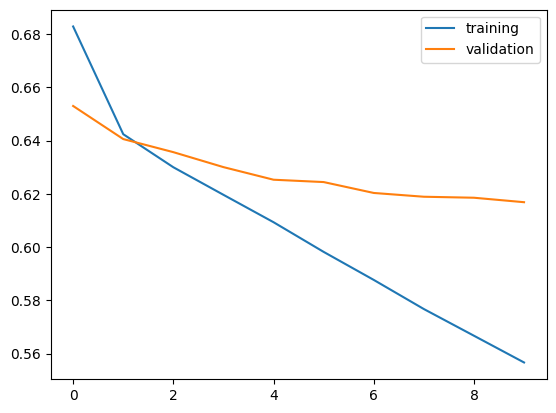

215/605 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_520CLONE', 'amount_invested_monthly': 'keras_tensor_535CLONE', 'annual_income': 'keras_tensor_521CLONE', 'changed_credit_limit': 'keras_tensor_531CLONE', 'credit_history_age': 'keras_tensor_523CLONE', 'credit_mix': 'keras_tensor_539CLONE', 'credit_utilization_ratio': 'keras_tensor_534CLONE', 'delay_from_due_date': 'keras_tensor_529CLONE', 'interest_rate': 'keras_tensor_527CLONE', 'month': 'keras_tensor_540CLONE', 'monthly_balance': 'keras_tensor_536CLONE', 'monthly_inhand_salary': 'keras_tensor_522CLONE', 'num_bank_accounts': 'keras_tensor_525CLONE', 'num_credit_card': 'keras_tensor_526CLONE', 'num_credit_inquiries': 'keras_tensor_532CLONE', 'num_of_delayed_payment': 'keras_tensor_530CLONE', 'num_of_loan': 'keras_tensor_528CLONE', 'occupation': 'keras_tensor_541CLONE', 'o

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step
[[3710 1438  349]
 [1253 7723 1325]
 [  76  914 2552]]
              precision    recall  f1-score   support

           0     0.7363    0.6749    0.7043      5497
           1     0.7666    0.7497    0.7580     10301
           2     0.6039    0.7205    0.6571      3542

    accuracy                         0.7231     19340
   macro avg     0.7022    0.7150    0.7065     19340
weighted avg     0.7281    0.7231    0.7243     19340



In [ ]:
crosses = []

hidden_units = [128, 64, 32]

training_model = build_wide_deep_networks(crosses, hidden_units)


history = training_model.fit(
    processed_train_ds,
    epochs=10,
    validation_data=processed_test_ds,
    verbose=2,
)
plot()
get_performance()

### Analysis

Compared with Model3, we can see that:
- The standard MLP has the same hidden layer structure ([128, 64, 32]) as model 3 but does not include a wide branch. However,the standarded MLP achieved similar performance to model3. This means that the deep branch alone was able to learn the relevant feature interactions from the data without needing explicitly crossed features.